# NLP-аналитика отзывов: тональность, аспекты и резюме (LLM/Qwen)

In [1]:
pip install "huggingface_hub[hf_xet]"

Note: you may need to restart the kernel to use updated packages.


In [2]:
import os
import re
import json
import numpy as np
import pandas as pd
from tqdm.auto import tqdm

import torch
from transformers import AutoTokenizer, AutoModelForCausalLM


D:\Conda\envs\nlp-gpu\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
D:\Conda\envs\nlp-gpu\Lib\site-packages\transformers\utils\hub.py:110: FutureWarning: Using `TRANSFORMERS_CACHE` is deprecated and will be removed in v5 of Transformers. Use `HF_HOME` instead.
  warnings.warn(


In [3]:
INPUT_PATH = "datasets/reviews.xlsx"
OUTPUT_PATH = "datasets/reviews_out.xlsx"

df = pd.read_excel(INPUT_PATH)

if df.shape[1] == 1:
    df.columns = ["review"]

REVIEW_COLUMN = "review"
if REVIEW_COLUMN not in df.columns:
    REVIEW_COLUMN = df.columns[0]

df[REVIEW_COLUMN] = df[REVIEW_COLUMN].astype(str)
df.head()


,review
0,"Ю Юлия А. Цвет товара: синий, Российский разме..."
1,"С Сергей Ш. Цвет товара: синий, Российский раз..."
2,"Цвет товара: серый, Российский размер: 50, Раз..."
3,"Ф Флера М. Цвет товара: белый, Российский разм..."
4,"С Сергей Т. изменен Цвет товара: черный, Росси..."


Из-за артефактов парсинга текст отзывов содержит много служебных вставок (имя, цвет, размер и т.п.), которые искажают обычные NLP-подходы (TF-IDF/ключевые слова/словари тональности). Поэтому для извлечения тональности и аспектов используется LLM, более устойчивый к шуму и умеющий “игнорировать” лишнее.

In [4]:
MODEL_NAME = "Qwen/Qwen2.5-3B-Instruct"

tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
model = AutoModelForCausalLM.from_pretrained(
    MODEL_NAME,
    torch_dtype="auto",
    device_map="auto"
)

print("cuda:", torch.cuda.is_available())
print("model device:", next(model.parameters()).device)


`torch_dtype` is deprecated! Use `dtype` instead!
Loading checkpoint shards: 100%|█████████████████████████████████████████████████████████| 2/2 [00:08<00:00,  4.27s/it]
Some parameters are on the meta device because they were offloaded to the cpu.


cuda: True
model device: cuda:0


In [5]:
SYSTEM_PROMPT = (
    "Ты аналитик отзывов маркетплейса. "
    "Выдай строго JSON без пояснений и без markdown. "
    "Поля: sentiment (positive|neutral|negative), aspect (quality|price|delivery|service|other), summary (коротко 5-15 слов). "
    "Игнорируй мусор, артикулы, случайные символы, обрывки."
)

def _extract_json(text: str) -> dict:
    m = re.search(r"\{.*\}", text, flags=re.S)
    if not m:
        return {"sentiment": "neutral", "aspect": "other", "summary": ""}
    try:
        return json.loads(m.group(0))
    except Exception:
        return {"sentiment": "neutral", "aspect": "other", "summary": ""}

@torch.inference_mode()
def analyze_review(review: str) -> dict:
    review = str(review).strip()
    if not review:
        return {"sentiment": "neutral", "aspect": "other", "summary": ""}

    messages = [
        {"role": "system", "content": SYSTEM_PROMPT},
        {"role": "user", "content": review[:4000]},
    ]

    prompt = tokenizer.apply_chat_template(messages, tokenize=False, add_generation_prompt=True)
    inputs = tokenizer(prompt, return_tensors="pt").to(model.device)

    out = model.generate(
        **inputs,
        max_new_tokens=200,
        do_sample=False,
        temperature=0.0,
        pad_token_id=tokenizer.eos_token_id
    )

    gen = tokenizer.decode(out[0][inputs["input_ids"].shape[1]:], skip_special_tokens=True).strip()
    data = _extract_json(gen)

    sentiment = data.get("sentiment", "neutral")
    aspect = data.get("aspect", "other")
    summary = data.get("summary", "")

    if sentiment not in {"positive", "neutral", "negative"}:
        sentiment = "neutral"
    if aspect not in {"quality", "price", "delivery", "service", "other"}:
        aspect = "other"
    if not isinstance(summary, str):
        summary = str(summary)

    return {"sentiment": sentiment, "aspect": aspect, "summary": summary}


In [6]:
tqdm.pandas()

res = df[REVIEW_COLUMN].progress_apply(analyze_review)
res_df = pd.json_normalize(res)

df["sentiment"] = res_df["sentiment"]
df["aspect"] = res_df["aspect"]
df["summary"] = res_df["summary"]

df.head()


100%|████████████████████████████████████████████████████████████████████████████████| 71/71 [1:17:13<00:00, 65.26s/it]


,review,sentiment,aspect,summary
0,"Ю Юлия А. Цвет товара: синий, Российский разме...",neutral,other,
1,"С Сергей Ш. Цвет товара: синий, Российский раз...",negative,quality,Ткань не соответствует ожиданиям
2,"Цвет товара: серый, Российский размер: 50, Раз...",neutral,other,
3,"Ф Флера М. Цвет товара: белый, Российский разм...",positive,quality,Худи хорошего качества
4,"С Сергей Т. изменен Цвет товара: черный, Росси...",neutral,other,


## Результат

Каждый отзыв автоматически размечается LLM (Qwen) по трём полям:
- `sentiment`: positive / neutral / negative
- `aspect`: quality / price / delivery / service / other
- `summary`: короткое резюме (5–15 слов)

Ниже — сводные метрики, распределения и примеры по сегментам.


Всего отзывов: 71
Тональность (кол-во):


,count
sentiment,
positive,29
neutral,34
negative,8


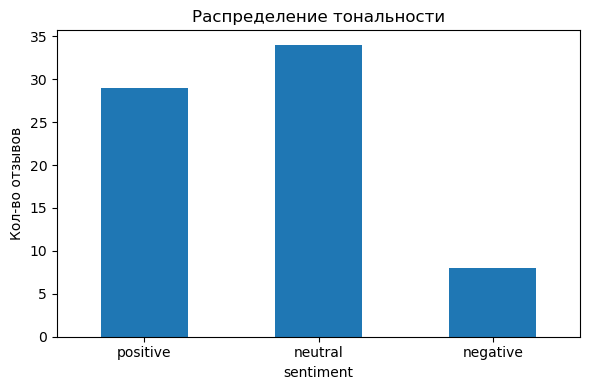

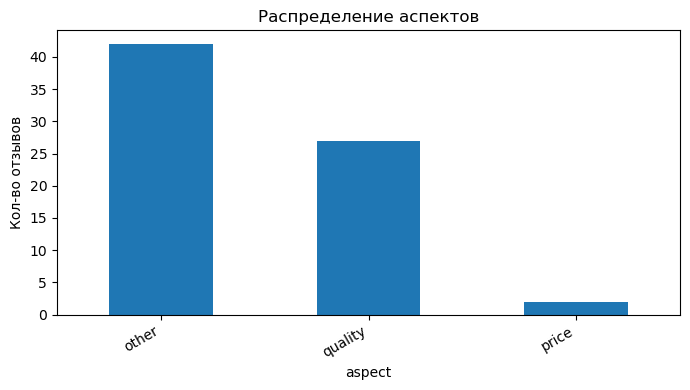

In [7]:
import matplotlib.pyplot as plt

n_total = len(df)
sent_order = ["positive", "neutral", "negative"]

sent_counts = df["sentiment"].value_counts().reindex(sent_order).fillna(0).astype(int)
aspect_counts = df["aspect"].value_counts()

print(f"Всего отзывов: {n_total}")
print("Тональность (кол-во):")
display(sent_counts.to_frame("count"))

plt.figure(figsize=(6,4))
sent_counts.plot(kind="bar")
plt.title("Распределение тональности")
plt.ylabel("Кол-во отзывов")
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

plt.figure(figsize=(7,4))
aspect_counts.plot(kind="bar")
plt.title("Распределение аспектов")
plt.ylabel("Кол-во отзывов")
plt.xticks(rotation=30, ha="right")
plt.tight_layout()
plt.show()


Распределение тональности показывает общий баланс классов тональности в датасете. В текущей выборке преобладают нейтральные и позитивные отзывы, а негативных заметно меньше — это важно учитывать при интерпретации итогов (редкий класс может быть менее стабильным).

Распределение аспектов отражает, какие темы (аспекты) модель чаще всего “видит” в отзывах. Доминирование other означает, что значительная часть текстов либо слишком общая/смешанная, либо не укладывается в заданные категории аспектов — это нормальная ситуация для коротких и шумных отзывов.

Тональность по аспектам (% внутри аспекта):


sentiment,positive,neutral,negative
aspect,,,
other,19.0,78.6,2.4
price,50.0,0.0,50.0
quality,74.1,3.7,22.2


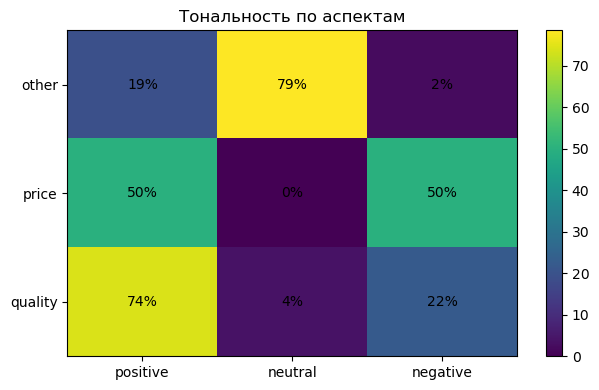

In [10]:
ct = pd.crosstab(df["aspect"], df["sentiment"], normalize="index") * 100
ct = ct.reindex(columns=["positive","neutral","negative"]).fillna(0)

print("Тональность по аспектам (% внутри аспекта):")
display(ct.round(1))

plt.figure(figsize=(6.5,4))
im = plt.imshow(ct.values, aspect="auto")
plt.colorbar(im)
plt.xticks(range(ct.shape[1]), ct.columns, rotation=0)
plt.yticks(range(ct.shape[0]), ct.index)

for i in range(ct.shape[0]):
    for j in range(ct.shape[1]):
        plt.text(j, i, f"{ct.values[i,j]:.0f}%", ha="center", va="center")

plt.title("Тональность по аспектам")
plt.tight_layout()
plt.show()


Тепловая карта показывает доли тональностей внутри каждого аспекта (строка суммарно ≈ 100%). Видно, что по quality чаще встречается позитив, а по price доли распределены поровну из-за малого числа примеров — такие строки стоит воспринимать осторожно при маленьких объёмах.

In [11]:
cols = [REVIEW_COLUMN, "summary", "sentiment", "aspect"]
def show_examples(aspect, sentiment, n=5):
    out = df[(df["aspect"]==aspect) & (df["sentiment"]==sentiment)][cols].head(n)
    return out

print("Примеры NEGATIVE по delivery:")
display(show_examples("delivery", "negative", n=5))

print("Примеры NEGATIVE по quality:")
display(show_examples("quality", "negative", n=5))

print("Примеры POSITIVE по quality:")
display(show_examples("quality", "positive", n=5))


Примеры NEGATIVE по delivery:


,review,summary,sentiment,aspect


Примеры NEGATIVE по quality:


,review,summary,sentiment,aspect
1,"С Сергей Ш. Цвет товара: синий, Российский раз...",Ткань не соответствует ожиданиям,negative,quality
7,"С Светлана Ш. Цвет товара: черный, Российский ...","Ждала долго, качество синтетика",negative,quality
39,"Ю Юлия П. Цвет товара: черный, Российский разм...","Качество неудовлетворительное, размер маломерит.",negative,quality
57,"А Алексей В. Цвет товара: белый, Российский ра...","Плохое качество, не соответствует размеру",negative,quality
59,"Ю Юлия Б. Цвет товара: белый, Российский разме...","Низкое качество, синтетика, низкая цена",negative,quality


Примеры POSITIVE по quality:


,review,summary,sentiment,aspect
3,"Ф Флера М. Цвет товара: белый, Российский разм...",Худи хорошего качества,positive,quality
5,"И Ирина Ч. Цвет товара: черный, Российский раз...",Супер качество для работы,positive,quality
11,"О Ольга Р. Цвет товара: белый, Российский разм...","Худи качественное, мягкое, красивое",positive,quality
12,"А Анна В. Цвет товара: фиолетовый, Российский ...","Цвет и качество удовлетворительны, цена приемл...",positive,quality
15,"Н Наталья П. Цвет товара: черный, Российский р...",худи отличное качество,positive,quality


Примеры — это качественная проверка: помогают быстро убедиться, что разметка “тональность + аспект” выглядит смыслово корректной. Такой блок полезен, чтобы видеть не только цифры, но и реальные тексты, которые формируют статистику.

In [8]:
ext = os.path.splitext(OUTPUT_PATH)[1].lower()
if ext in [".xlsx", ".xls"]:
    df.to_excel(OUTPUT_PATH, index=False)
else:
    df.to_csv(OUTPUT_PATH, index=False, encoding="utf-8-sig")

OUTPUT_PATH


'datasets/reviews_out.xlsx'